# Short Bursts

We look at the behavior of using short bursts to increase number of opportunity districts for bvap and it projection into the line model

In [1]:
import matplotlib.pyplot as plt
from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election)
from gerrychain.proposals import recom, propose_random_flip
from gerrychain.tree import recursive_tree_part
from gerrychain.metrics import mean_median, efficiency_gap, polsby_popper, partisan_gini
from functools import (partial, reduce)
import pandas
import geopandas as gp
import numpy as np
import networkx as nx
import pickle
import seaborn as sns
import pprint
import operator
import scipy
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, normalize
import random
from nltk.util import bigrams
from nltk.probability import FreqDist
import pylab

In [2]:
## This function takes a name of a shapefile and returns a tuple of the graph
## and its associated dataframe
def build_graph(filename):
    print("Pulling in Graph from Shapefile: " + filename)
    graph = Graph.from_file(filename)
    df = gp.read_file(filename)
    return(graph, df)

In [3]:
def config_markov_chain(initial_part, iters=1000, epsilon=0.05, compactness=True, pop="TOT_POP"):
    # The recom proposal needs to know the ideal population for the districts so
    # that we can improve speed by bailing early on unbalanced partitions.
    ideal_population = sum(initial_part["population"].values()) / len(initial_part)


    # We use functools.partial to bind the extra parameters (pop_col, pop_target,
    # epsilon, node_repeats) of the recom proposal.
    proposal = partial(recom,
                       pop_col=pop,
                       pop_target=ideal_population,
                       epsilon=epsilon,
                       node_repeats=1)

    # To keep districts about as compact as the original plan, we bound the number
    # of cut edges at 2 times the number of cut edges in the initial plan.
    if compactness:
        compactness_bound = constraints.UpperBound(lambda p: len(p["cut_edges"]),
                            2*len(initial_part["cut_edges"]))
        cs = [constraints.within_percent_of_ideal_population(initial_part, epsilon), compactness_bound]
    else:
        cs = [constraints.within_percent_of_ideal_population(initial_part, epsilon)]


    # Configure the MarkovChain.
    return MarkovChain(proposal=proposal, constraints=cs, accept=accept.always_accept,
                       initial_state=initial_part, total_steps=iters)

## Functions to Simulate Short Bursts

In [4]:
## This function takes a partition and returns the number o
def num_opportunity_dists(part, minority_prec="bvap_prec"):
    dist_precs = part[minority_prec].values()
    return sum(list(map(lambda v: v >= 0.35, dist_precs)))

In [16]:
def short_burst_run(starting_part, score_func, num_bursts=10, num_steps=100, verbose=False,
                    pop="TOT_POP"):
    max_part = (starting_part, num_opportunity_dists(starting_part))
    observed_num_ops = np.zeros((num_bursts, num_steps))

    for i in range(num_bursts):
        if verbose: print("Burst:", i)
        chain = config_markov_chain(max_part[0], iters=num_steps, epsilon=0.1, pop=pop)

        for j, part in enumerate(chain):
            part_score = num_opportunity_dists(part)
            observed_num_ops[i][j] = part_score
            max_part = (part, part_score) if part_score >= max_part[1] else max_part
    
    return (max_part, observed_num_ops)

## Pull in PA data and set up partitions

In [8]:
# graph_PA, df_PA = build_graph("PA_shape/PA_VTD.shp")
graph_PA = pickle.load(open("PA_graph.p", "rb"))
df_PA = pickle.load(open("PA_df.p", "rb"))

In [9]:
PA_updaters = {"population": updaters.Tally("TOT_POP", alias="population"),
               "bvap": updaters.Tally("BLACK_POP", alias="bvap"),
               "vap": updaters.Tally("VAP", alias="vap"),
               "bvap_prec": lambda part: {k: part["bvap"][k] / part["population"][k] for k in part["bvap"]}}

In [17]:
total_population_PA = sum(df_PA.TOT_POP.values)
ideal_population_PA = total_population_PA / 50
seed_part_senate = recursive_tree_part(graph_PA, range(50), pop_col="TOT_POP",
                                pop_target=ideal_population_PA,
                                epsilon=0.01, node_repeats=1)
PA_seed_seante = GeographicPartition(graph_PA, assignment=seed_part_senate,updaters=PA_updaters)

In [223]:
seed_part_house = recursive_tree_part(graph_PA, range(203), pop_col="TOT_POP",
                                pop_target=ideal_population_PA,
                                epsilon=0.01, node_repeats=1)
PA_seed_house = GeographicPartition(graph_PA, assignment=seed_part_house,updaters=PA_updaters)

KeyboardInterrupt: 

In [10]:
enacted_senate = GeographicPartition(graph_PA, assignment="SSD", updaters=PA_updaters)

In [11]:
num_opportunity_dists(enacted_senate)

4

## Pull in AR data and set up partitions

In [6]:
graph_AR, df_AR = build_graph("AR_shape/AR.shp")

Pulling in Graph from Shapefile: AR_shape/AR.shp


In [57]:
AR_updaters = {"population": updaters.Tally("TOTPOP", alias="population"),
               "bvap": updaters.Tally("BVAP", alias="bvap"),
               "vap": updaters.Tally("VAP", alias="vap"),
               "bvap_prec": lambda part: {k: part["bvap"][k] / part["vap"][k]
                                          for k in part["bvap"]}}

In [268]:
AR_enacted_senate = GeographicPartition(graph_AR, assignment="SSD", updaters=AR_updaters)

In [271]:
num_opportunity_dists(AR_enacted_senate)

4

In [10]:
total_population_AR = sum(df_AR.TOTPOP.values)
ideal_population_AR = total_population_AR / 35

In [17]:
senate_seed = recursive_tree_part(graph_AR, range(35), pop_col="TOTPOP",
                                pop_target=ideal_population_AR,
                                epsilon=0.01, node_repeats=1)
AR_seed_senate = GeographicPartition(graph_AR, assignment=senate_seed,updaters=AR_updaters)

In [18]:
num_opportunity_dists(AR_seed_senate)

4

In [ ]:
house_seed = recursive_tree_part(graph_AR, range(100), pop_col="TOTPOP",
                                pop_target=ideal_population_AR,
                                epsilon=0.01, node_repeats=1)
AR_seed_house = GeographicPartition(graph_AR, assignment=house_seed,updaters=AR_updaters)

### How does burst length affect findings

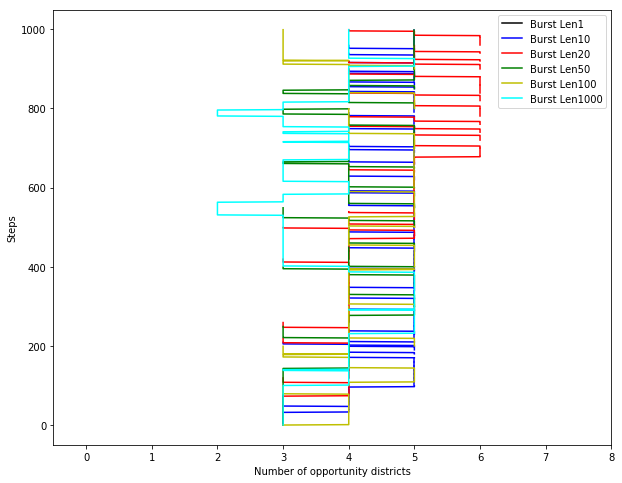

In [209]:
plt.figure(figsize=(10,8))
plt.xlim(-.5, 8)
plt.xlabel("Number of opportunity districts")
plt.ylabel("Steps")
plt.title("PA short bursts of different lengths")

total_steps = 1000

for color, len_burst in [("k", 1), ("b", 5), ("r", 25), ("g", 50), ("y", 100),
                         ("cyan", 1000)]:
    print(len_burst)
    num_bursts =  int(total_steps / len_burst)
    _, observations = short_burst_run(enacted_senate, num_opportunity_dists,
                                      num_bursts=num_bursts, num_steps=len_burst)

    for i in range(num_bursts):
        plt.plot(observations[i], range(len_burst*i, len_burst*(i+1)),
                 color=color, alpha=0.5, marker=".", markevery=[0,-1])
    plt.plot([], color=color, label=("Burst_len " + str(len_burst)))
    
plt.legend()
plt.show()

1
5
25
50
100
1000


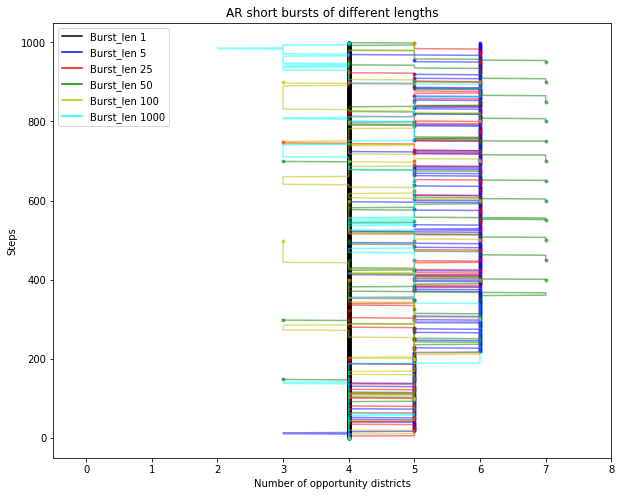

In [49]:
plt.figure(figsize=(10,8))
plt.xlim(-.5, 8)
plt.xlabel("Number of opportunity districts")
plt.ylabel("Steps")
plt.title("AR short bursts of different lengths")

total_steps = 1000

for color, len_burst in [("k", 1), ("b", 5), ("r", 25), ("g", 50), ("y", 100),
                         ("cyan", 1000)]:
    print(len_burst)
    num_bursts =  int(total_steps / len_burst)
    _, observations = short_burst_run(AR_seed_senate, num_opportunity_dists,
                                      num_bursts=num_bursts, num_steps=len_burst, pop="TOTPOP")

    for i in range(num_bursts):
        plt.plot(observations[i], range(len_burst*i, len_burst*(i+1)),
                 color=color, alpha=0.5, marker=".", markevery=[0,-1])
    plt.plot([], color=color, label=("Burst_len " + str(len_burst)))
    
plt.legend()
plt.show()

## Run on PA state senate and visualizing results

In [13]:
num_bursts = 50
num_steps = 10

In [18]:
max_part, observed_num_ops = short_burst_run(enacted_senate, num_opportunity_dists,
                                             num_bursts=num_bursts, num_steps=num_steps)

Burst: 0
Burst: 1
Burst: 2
Burst: 3
Burst: 4
Burst: 5
Burst: 6
Burst: 7
Burst: 8
Burst: 9
Burst: 10
Burst: 11
Burst: 12
Burst: 13
Burst: 14
Burst: 15
Burst: 16
Burst: 17
Burst: 18
Burst: 19
Burst: 20
Burst: 21
Burst: 22
Burst: 23
Burst: 24
Burst: 25
Burst: 26
Burst: 27
Burst: 28
Burst: 29
Burst: 30
Burst: 31
Burst: 32
Burst: 33
Burst: 34
Burst: 35
Burst: 36
Burst: 37
Burst: 38
Burst: 39
Burst: 40
Burst: 41
Burst: 42
Burst: 43
Burst: 44
Burst: 45
Burst: 46
Burst: 47
Burst: 48
Burst: 49


In [23]:
_, observed_num_ops_flat = short_burst_run(enacted_senate, num_opportunity_dists,
                                             num_bursts=1, num_steps=500)

(array([ 61.,   0.,   0., 179.,   0.,   0., 189.,   0.,   0.,  71.]),
 array([4. , 4.3, 4.6, 4.9, 5.2, 5.5, 5.8, 6.1, 6.4, 6.7, 7. ]),
 <a list of 10 Patch objects>)

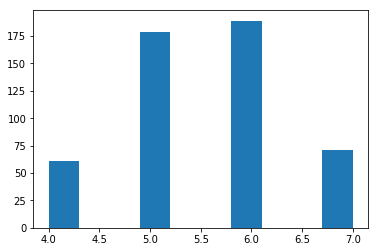

In [22]:
plt.hist(observed_num_ops.flatten())

/home/smaug/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


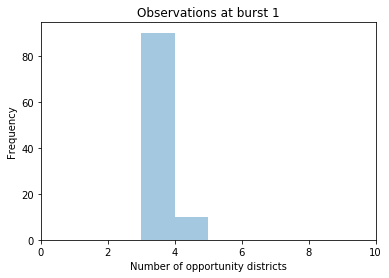

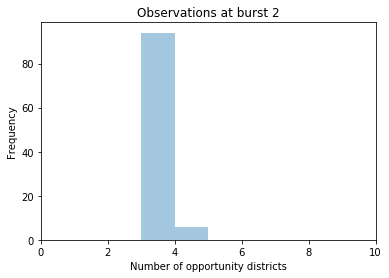

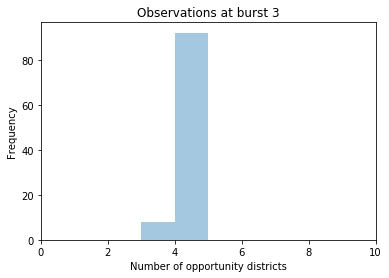

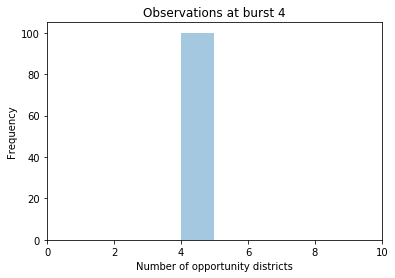

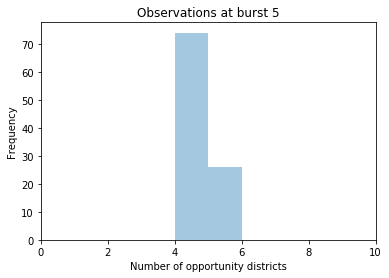

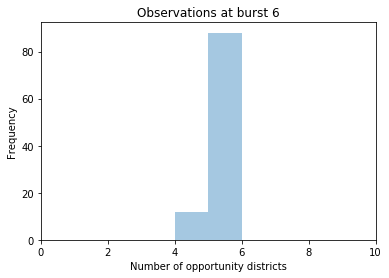

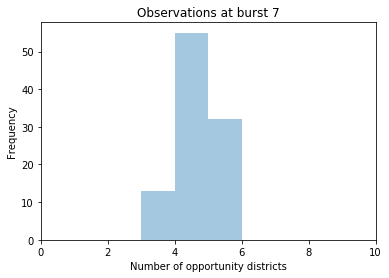

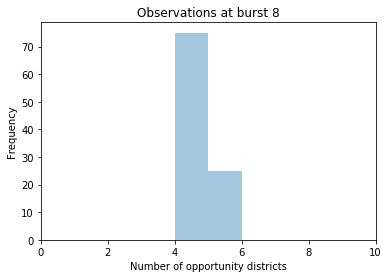

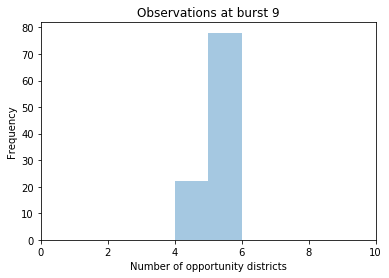

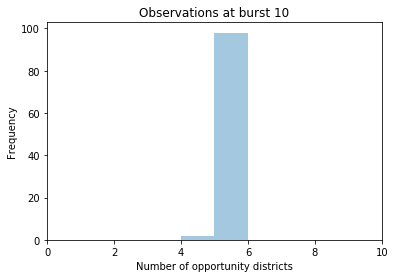

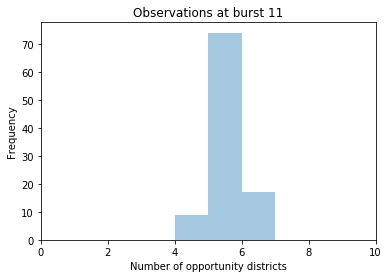

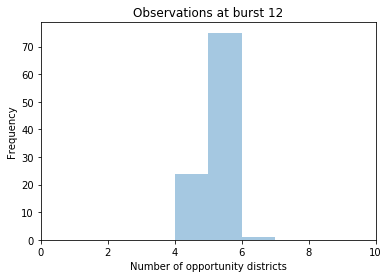

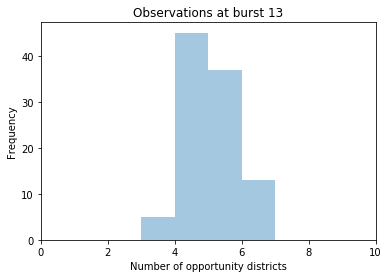

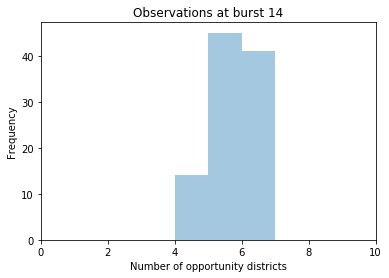

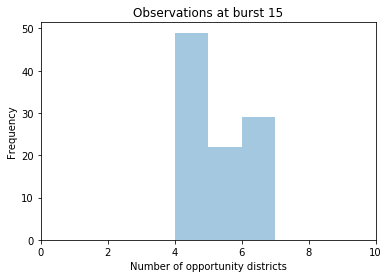

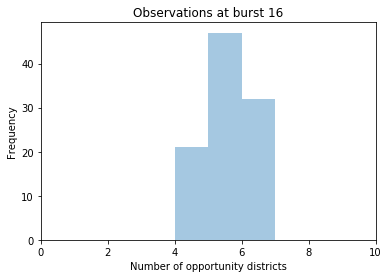

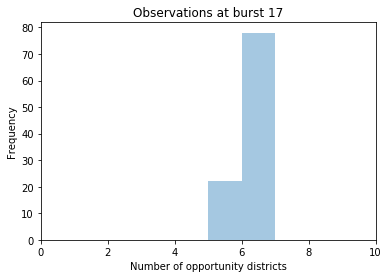

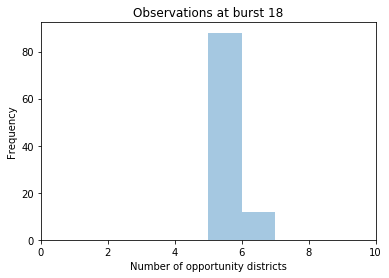

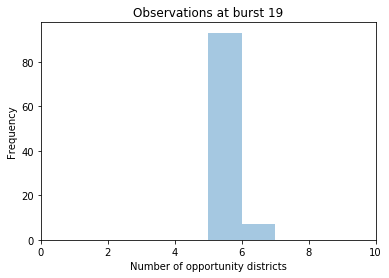

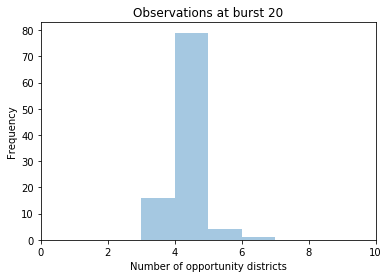

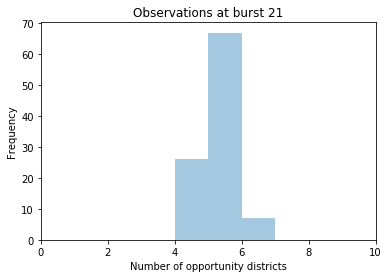

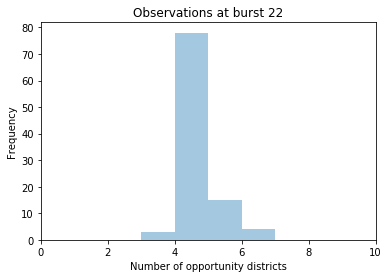

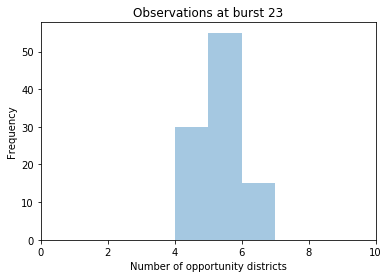

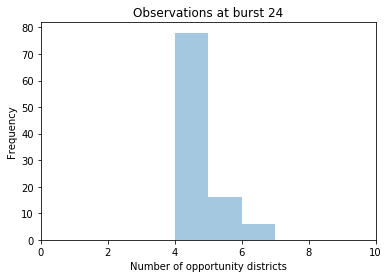

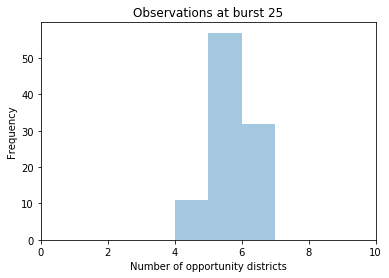

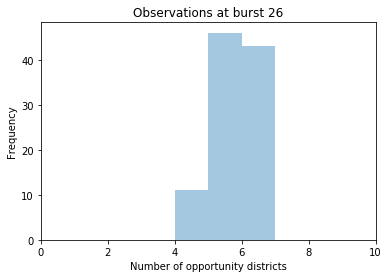

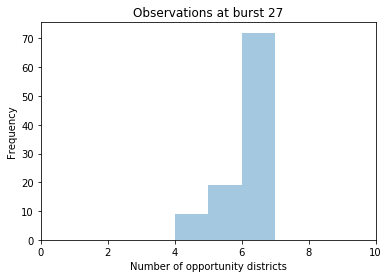

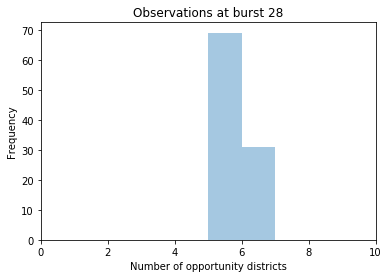

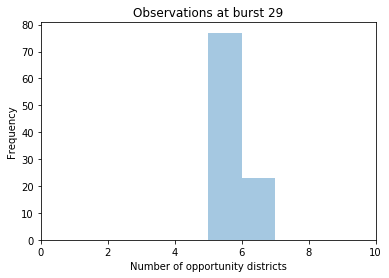

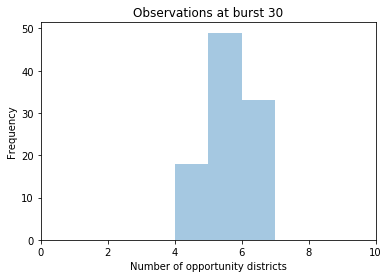

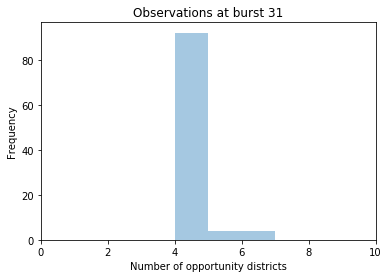

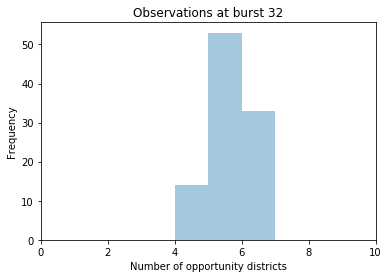

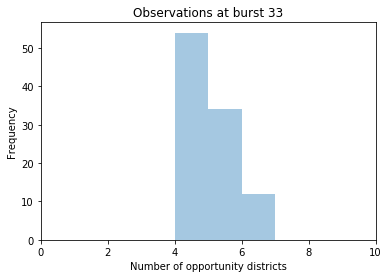

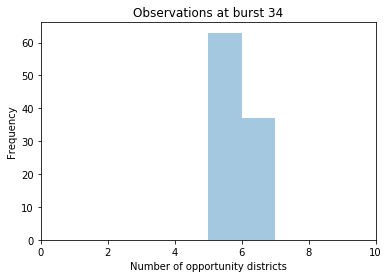

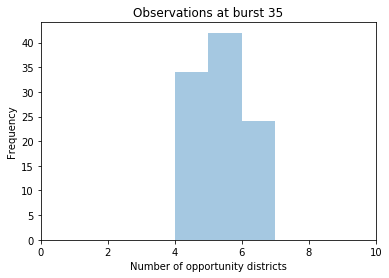

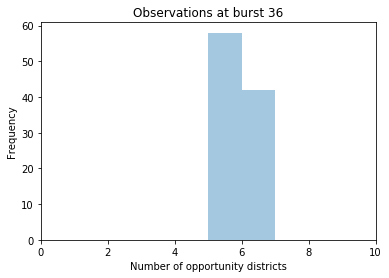

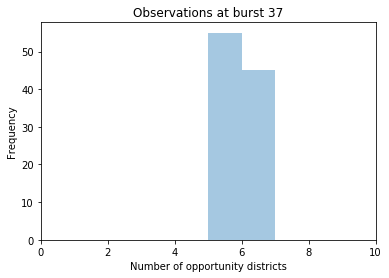

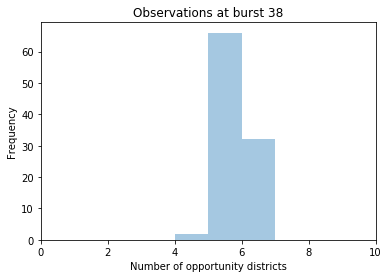

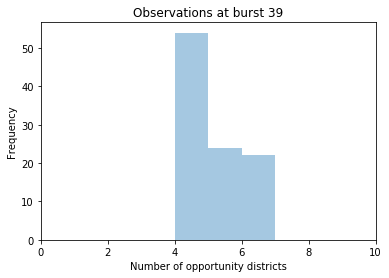

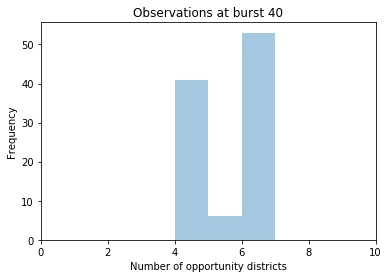

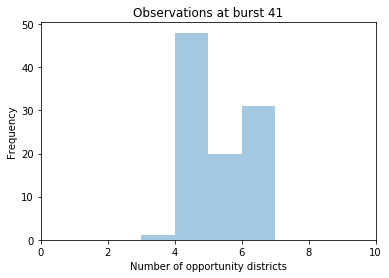

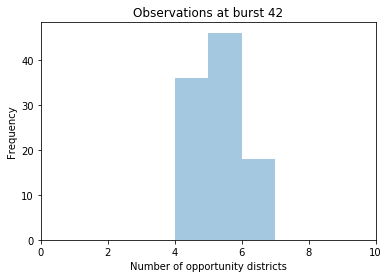

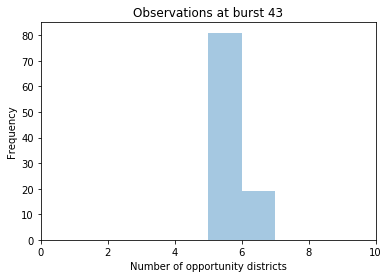

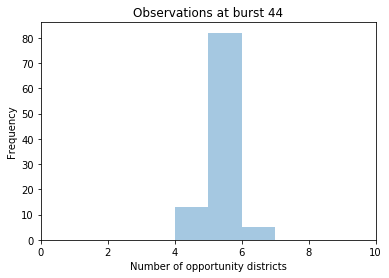

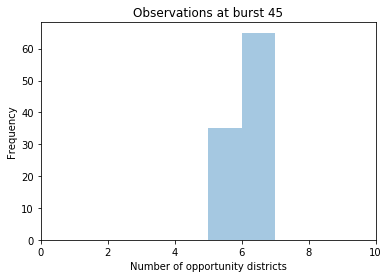

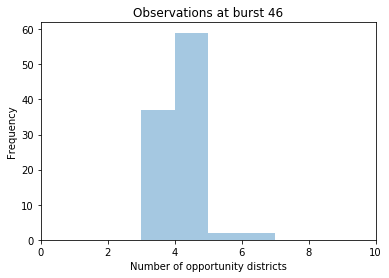

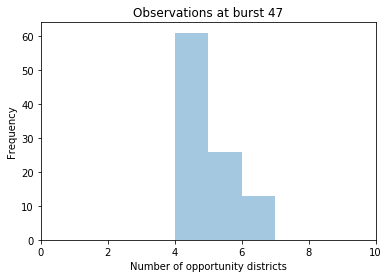

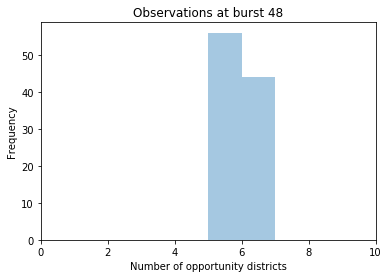

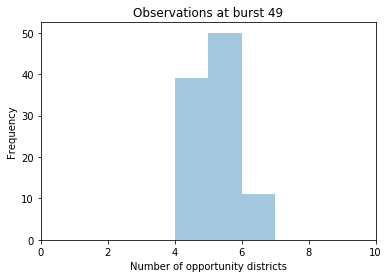

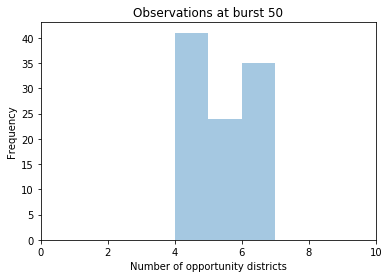

In [106]:
for i, row in enumerate(observed_num_ops):
    plt.figure()
    plt.title("Observations at burst " + str(i + 1))
    plt.xlabel("Number of opportunity districts")
    plt.ylabel("Frequency")
    plt.xlim(0,10)
    bins = np.linspace(0, 10, 11)
    sns.distplot(row, kde=False, bins=bins)
    #plt.savefig("plots/PA_senate_10_100_seed_3/short_burst_" + str(i+1) + "_hist.png")

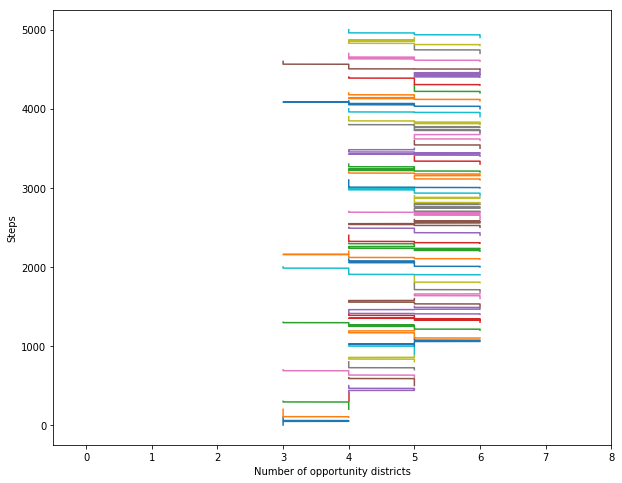

In [107]:
names = list(map(lambda i: "Burst " + str(i), range(1,num_bursts + 1)))
plt.figure(figsize=(10,8))
plt.xlim(-.5, 8)
plt.xlabel("Number of opportunity districts")
plt.ylabel("Steps")
for i in range(num_bursts):
    plt.plot(observed_num_ops[i], range(num_steps*i, num_steps*(i+1)))#, label=names[i])
# plt.legend()
# plt.savefig("plots/burst_walk_100_100.png")

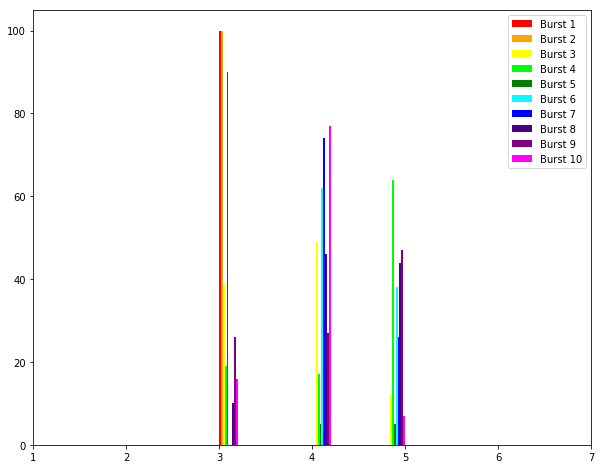

In [46]:
plt.figure(figsize=(10,8))
colors = ["red", "orange", "yellow", "lime", "green",
          "cyan", "blue", "indigo", "purple", "fuchsia"]
names = list(map(lambda i: "Burst " + str(i), range(1,num_bursts + 1)))
             
plt.hist(list(observed_num_ops), color=colors, label=names, align='mid', rwidth=10)
plt.xlim(1,7)
plt.legend()
plt.show()

## Reprojecting bursts onto the line

## AR

In [45]:
_, observed_num_ops_AR = short_burst_run(AR_seed_senate, num_opportunity_dists,
                                             num_bursts=1000, num_steps=10, pop="TOTPOP")

In [37]:
transitions_AR = []
for row in observed_num_ops_AR:
    transitions_AR.extend(bigrams(row))

In [38]:
fdist_AR = FreqDist(transitions_AR)
probs = {}
N = np.matrix(observed_num_ops_AR).astype(int)
dim = N.max()
A = np.zeros((dim, dim))
for k, v in fdist_AR.items():
    p = v / fdist_AR.N()
    probs[k] = p
    A[int(k[0]) - 1][int(k[1]) - 1] = p

In [39]:
A_normed = normalize(A, norm="l1")

In [40]:
G = nx.from_numpy_array(A_normed, create_using=nx.DiGraph)

In [41]:
mapping = {n: n+1 for n in G.nodes}
G1 = nx.relabel_nodes(G, mapping)

In [42]:
AR_line_proj=dict([((u,v,), round(d['weight'],4))
                 for u,v,d in G1.edges(data=True)])

In [43]:
AR_line_proj

{(2, 2): 1.0,
 (3, 2): 0.0769,
 (3, 3): 0.9231,
 (4, 3): 0.0275,
 (4, 4): 0.9541,
 (4, 5): 0.0183,
 (5, 4): 0.0576,
 (5, 5): 0.9333,
 (5, 6): 0.0091,
 (6, 5): 0.0984,
 (6, 6): 0.9016}

## PA

In [108]:
transitions = []
for row in observed_num_ops:
    transitions.extend(bigrams(row))

In [109]:
fdist = FreqDist(transitions)

In [110]:
fdist

FreqDist({(5.0, 5.0): 2068, (4.0, 4.0): 1484, (6.0, 6.0): 985, (3.0, 3.0): 257, (6.0, 5.0): 56, (5.0, 4.0): 47, (4.0, 5.0): 21, (5.0, 6.0): 20, (4.0, 3.0): 9, (3.0, 4.0): 3})

In [111]:
probs = {}
N = np.matrix(observed_num_ops).astype(int)
dim = N.max()
A = np.zeros((dim, dim))

In [113]:
for k, v in fdist.items():
    p = v / fdist.N()
    probs[k] = p
    A[int(k[0]) - 1][int(k[1]) - 1] = p

In [149]:
A_normed = normalize(A, norm="l1")

In [153]:
A_normed[2]

array([0.        , 0.        , 0.98846154, 0.01153846, 0.        ,
       0.        ])

In [156]:
G = nx.from_numpy_array(A_normed, create_using=nx.DiGraph)

In [157]:
G.edges(data=True)

OutEdgeDataView([(2, 2, {'weight': 0.9884615384615385}), (2, 3, {'weight': 0.011538461538461539}), (3, 2, {'weight': 0.0059445178335535}), (3, 3, {'weight': 0.9801849405548215}), (3, 4, {'weight': 0.013870541611624834}), (4, 3, {'weight': 0.02201405152224824}), (4, 4, {'weight': 0.9686182669789226}), (4, 5, {'weight': 0.009367681498829038}), (5, 4, {'weight': 0.05379442843419789}), (5, 5, {'weight': 0.9462055715658022})])

In [166]:
mapping = {n: n+1 for n in G.nodes}
G1 = nx.relabel_nodes(G, mapping)

In [167]:
PA_line_proj=dict([((u,v,), round(d['weight'],4))
                 for u,v,d in G1.edges(data=True)])

In [211]:
PA_line_proj

{(3, 3): 0.9885,
 (3, 4): 0.0115,
 (4, 3): 0.0059,
 (4, 4): 0.9802,
 (4, 5): 0.0139,
 (5, 4): 0.022,
 (5, 5): 0.9686,
 (5, 6): 0.0094,
 (6, 5): 0.0538,
 (6, 6): 0.9462}

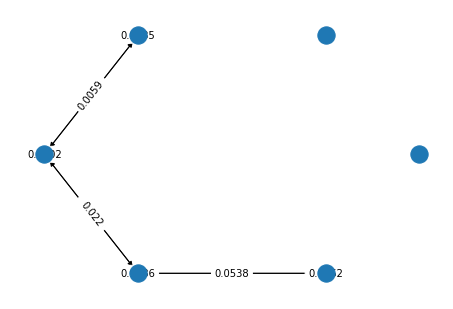

In [169]:
plt.figure()
pos=nx.shell_layout(G1)
nx.draw(G1, pos=pos, edge_cmap=plt.cm.Reds)
nx.draw_networkx_edge_labels(G1,pos=pos,edge_labels=edge_labels)
plt.show()

In [116]:
H = nx.DiGraph()
for (n1,n2) in probs:
    H.add_edges_from([(n1, n2)], weight=probs[n1,n2])


In [117]:
edge_labels=dict([((u,v,), round(d['weight'],4))
                 for u,v,d in H.edges(data=True)])

In [118]:
edge_labels

{(3.0, 3.0): 0.0519,
 (3.0, 4.0): 0.0006,
 (4.0, 4.0): 0.2998,
 (4.0, 3.0): 0.0018,
 (4.0, 5.0): 0.0042,
 (5.0, 5.0): 0.4178,
 (5.0, 4.0): 0.0095,
 (5.0, 6.0): 0.004,
 (6.0, 6.0): 0.199,
 (6.0, 5.0): 0.0113}

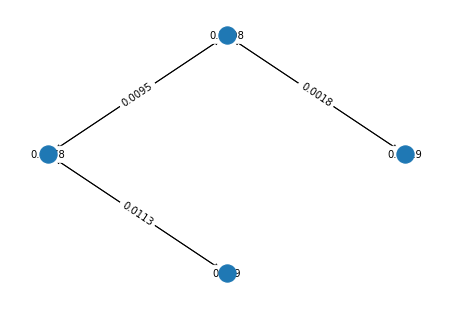

In [119]:
plt.figure()
pos=nx.shell_layout(H)
nx.draw(H, pos=pos, edge_cmap=plt.cm.Reds)
nx.draw_networkx_edge_labels(H,pos=pos,edge_labels=edge_labels)
plt.show()


In [189]:
from networkx.drawing.nx_agraph import write_dot

ImportError: ('requires pygraphviz ', 'http://pygraphviz.github.io/')

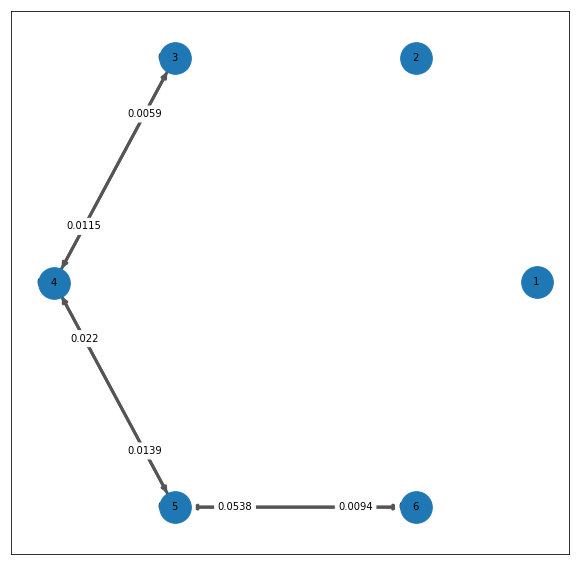

In [191]:
plt.figure(figsize=(10,10))
nx.draw_networkx(
    G1, pos=nx.circular_layout(G1),
    node_shape='o', node_size=1000, font_size=10,
    edge_color='#555555', width=3.0
)
nx.draw_networkx_edge_labels(
    G1, pos=nx.circular_layout(G1), 
    edge_labels=edge_labels,
    font_size=10, label_pos=0.25, rotate=False
)
# plt.axis('off')
write_dot(G,'graph.dot')

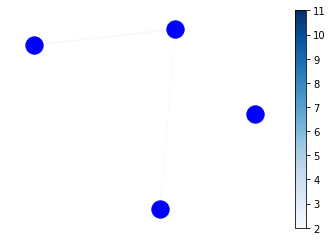

In [137]:
from __future__ import division
import matplotlib as mpl

G = H
pos = nx.layout.spring_layout(G)

# node_sizes = [3 + 10 * i for i in range(len(G))]
M = G.number_of_edges()
edge_colors = range(2, M + 2)
edge_alphas = [round(d['weight'],4)*2 for u,v,d in H.edges(data=True)]

nodes = nx.draw_networkx_nodes(G, pos, node_color='blue')
edges = nx.draw_networkx_edges(G, pos, arrowstyle='->',
                               arrowsize=10, edge_color=edge_colors,
                               edge_cmap=plt.cm.Blues, width=2)
# set alpha value for each edge
for i in range(M):
    edges[i].set_alpha(edge_alphas[i])

pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.Blues)
pc.set_array(edge_colors)
plt.colorbar(pc)

ax = plt.gca()
ax.set_axis_off()
plt.show()